In [73]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report
from models import CNNClassifier
import warnings
warnings.filterwarnings('ignore')

In [89]:
nconf = 50
t_sum = 0.9
prm_list = []
for i in range(nconf + 1):
    prm_list.append([t_sum, f"dataset/2d_Clock/L64_q=4/L64T{i}_"])
    t_sum += 0.01
print(prm_list)
# Temterature30 x conf50 = 3000 data

[[0.9, 'dataset/2d_Clock/L64_q=4/L64T0_'], [0.91, 'dataset/2d_Clock/L64_q=4/L64T1_'], [0.92, 'dataset/2d_Clock/L64_q=4/L64T2_'], [0.93, 'dataset/2d_Clock/L64_q=4/L64T3_'], [0.9400000000000001, 'dataset/2d_Clock/L64_q=4/L64T4_'], [0.9500000000000001, 'dataset/2d_Clock/L64_q=4/L64T5_'], [0.9600000000000001, 'dataset/2d_Clock/L64_q=4/L64T6_'], [0.9700000000000001, 'dataset/2d_Clock/L64_q=4/L64T7_'], [0.9800000000000001, 'dataset/2d_Clock/L64_q=4/L64T8_'], [0.9900000000000001, 'dataset/2d_Clock/L64_q=4/L64T9_'], [1.0, 'dataset/2d_Clock/L64_q=4/L64T10_'], [1.01, 'dataset/2d_Clock/L64_q=4/L64T11_'], [1.02, 'dataset/2d_Clock/L64_q=4/L64T12_'], [1.03, 'dataset/2d_Clock/L64_q=4/L64T13_'], [1.04, 'dataset/2d_Clock/L64_q=4/L64T14_'], [1.05, 'dataset/2d_Clock/L64_q=4/L64T15_'], [1.06, 'dataset/2d_Clock/L64_q=4/L64T16_'], [1.07, 'dataset/2d_Clock/L64_q=4/L64T17_'], [1.08, 'dataset/2d_Clock/L64_q=4/L64T18_'], [1.09, 'dataset/2d_Clock/L64_q=4/L64T19_'], [1.1, 'dataset/2d_Clock/L64_q=4/L64T20_'], [1.1

17


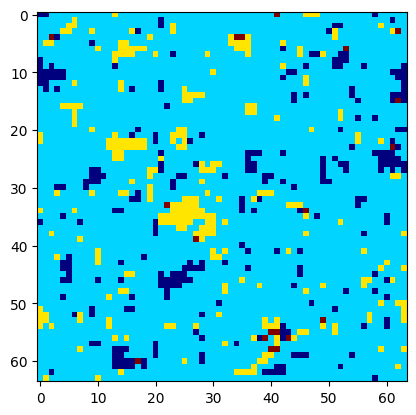

19


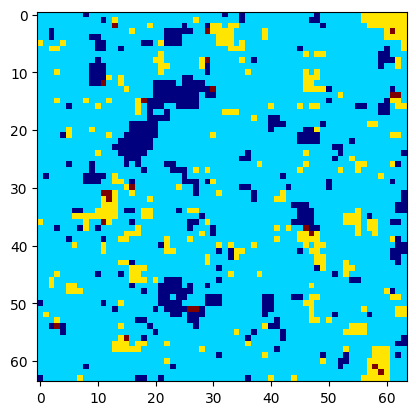

21


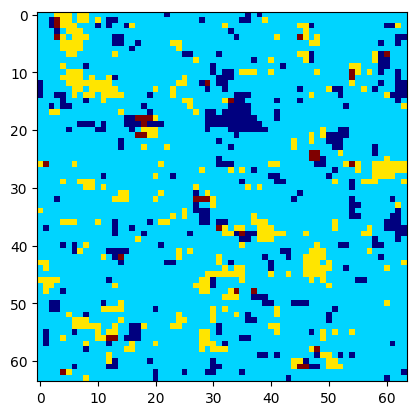

23


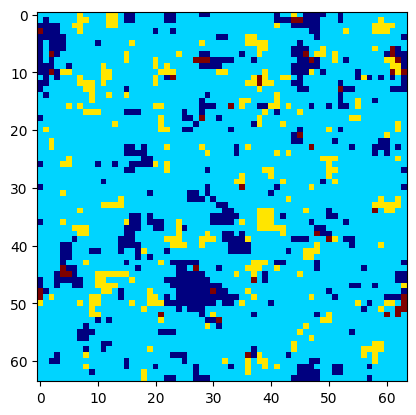

25


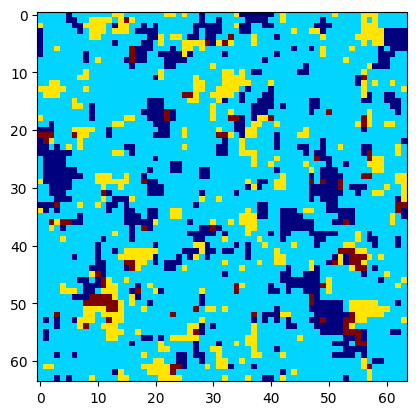

In [90]:
for num in ["17", "19", "21", "23", "25"]:
    for iconf in range(1):
        file = f"dataset/2d_Clock/L64_q=4/L64T{num}_{iconf}.npy"
        print(num)
        sc = np.load(file)
        plt.imshow(sc, interpolation='nearest', vmin=0, vmax=3, cmap='jet')
        plt.show()

In [91]:
ndata = 25
T_cr = 1/np.log(1+np.sqrt(2)) # critical temp for 2d 4-Clock

data = []
labels = []
temps = []
nprm = len(prm_list)
for itemp in range(nprm):
    temp = prm_list[itemp][0]
    fname = prm_list[itemp][1]
    for itrj in range(ndata):
        npsc = np.load(f"{fname}{itrj}.npy")
        data.append(npsc)
        if temp > T_cr:
            labels.append(1)
        else:
            labels.append(0)
        temps.append(temp)
data = torch.tensor(data, dtype=torch.float32).unsqueeze(1)
labels = torch.tensor(labels, dtype=torch.float32)
train_data = data[0::2]
train_labels = labels[0::2]
train_temps = temps[0::2]
val_data = data[1::2]
val_labels = labels[1::2]
val_temps = temps[1::2]

In [92]:
print("train_data.shape = ", train_data.shape)
print("train_labels.shape = ", train_labels.shape)
print("val_data.shape = ", val_data.shape)

train_data.shape =  torch.Size([638, 1, 64, 64])
train_labels.shape =  torch.Size([638])
val_data.shape =  torch.Size([637, 1, 64, 64])


In [93]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [94]:
epochs = 5
losses = []
accuracy_list = []
for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.type(torch.long))
        loss.backward()
        del loss
        optimizer.step()
    
    model.eval()
    valid_loss = 0
    correct = 0
    answer = []
    prediction = []
    with torch.no_grad():
        for data, target in valid_loader:
            output = model(data)
            valid_loss += criterion(output, target.type(torch.long)).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            prediction += list(pred.cpu().numpy())
            answer += list(target.cpu().numpy())

    valid_loss /= len(valid_loader.dataset)
    accuracy = 100 * correct / len(valid_loader.dataset)
    losses.append(valid_loss)
    accuracy_list.append(accuracy)
    print(f'Epoch: {epoch+1}, Validation loss: {valid_loss}, Accuracy: {accuracy}%')
    print("Classification Report:\n", classification_report(
        answer, prediction, digits=4))
print("done.")
torch.save(model, "2d_Clock_model_classifier.pth")

Epoch: 1, Validation loss: 0.06991386752411993, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       187
         1.0     0.5168    1.0000    0.6814       200

    accuracy                         0.5168       387
   macro avg     0.2584    0.5000    0.3407       387
weighted avg     0.2671    0.5168    0.3522       387

Epoch: 2, Validation loss: 0.06977192144985347, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-score   support

         0.0     0.0000    0.0000    0.0000       187
         1.0     0.5168    1.0000    0.6814       200

    accuracy                         0.5168       387
   macro avg     0.2584    0.5000    0.3407       387
weighted avg     0.2671    0.5168    0.3522       387

Epoch: 3, Validation loss: 0.06977148742946851, Accuracy: 51.679586563307495%
Classification Report:
               precision    recall  f1-sc

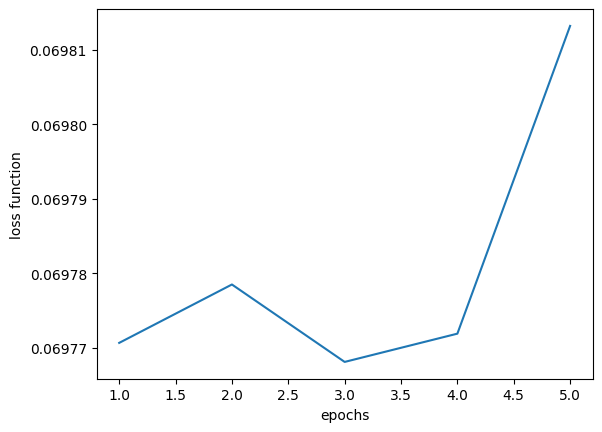

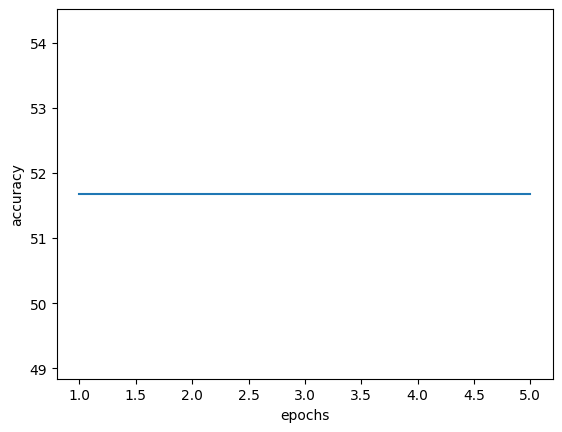

In [87]:
plt.xlabel('epochs')
plt.ylabel('loss function')
plt.plot(np.arange(1, epochs+1), losses)
plt.show()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(np.arange(1, epochs+1), accuracy_list)
plt.show()

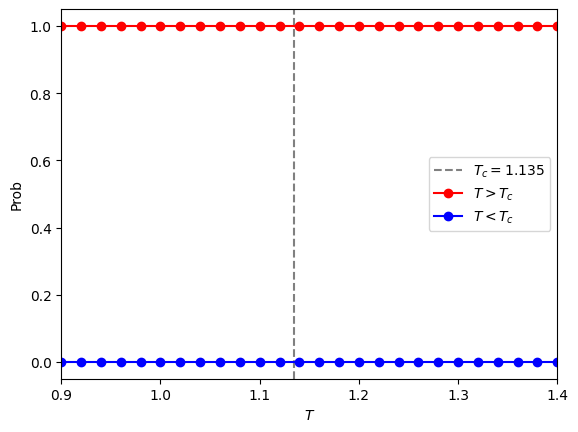

In [88]:
xs = []
y1s = []
y2s = []
Ndatamax = 637
Nsameclass = 25
for j in range(0, Ndatamax, Nsameclass):
    result = model(val_data[j:j+Nsameclass])
    x = val_temps[j]
    y1 = np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    y2 = 1 - np.mean(result.argmax(dim=1, keepdim=True).detach().numpy().copy())
    xs.append(x)
    y1s.append(y1)
    y2s.append(y2)
    # print(x, y1, y2)
plt.axvline(x=1.135, ymin=0, ymax=1, ls="dashed", color="gray", label=r"$T_c=1.135$")
plt.xlim(0.9,1.4)
plt.plot(xs, y1s, label=r"$T>T_c$", marker="o", color="red")
plt.plot(xs, y2s, label=r"$T<T_c$", marker="o", color="blue")
plt.legend()
plt.xlabel(r"$T$")
plt.ylabel(r"Prob")
plt.show()